In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import linregress,stats
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from prophet import Prophet
import statsmodels.api as sm
from sklearn.metrics import r2_score,mean_absolute_error
pd.options.display.float_format = "{:.2f}".format

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df=pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df2=df.copy()
df2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.00,0,1,Yes,Private,Urban,228.69,36.60,formerly smoked,1
1,51676,Female,61.00,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.00,0,1,Yes,Private,Rural,105.92,32.50,never smoked,1
3,60182,Female,49.00,0,0,Yes,Private,Urban,171.23,34.40,smokes,1
4,1665,Female,79.00,1,0,Yes,Self-employed,Rural,174.12,24.00,never smoked,1


In [3]:
# 'id' sütununu kaldıralım
df2.drop('id', axis=1, inplace=True)

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [5]:
df2.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
# 'age' sütununu float'tan int'e dönüştürelim
df2['age'] = df2['age'].astype(int)

In [7]:
df2.shape

(5110, 11)

In [8]:
# 'age' sütununda 0'dan küçük olan satırları filtreleyelim
df2 = df2[df2['age'] > 0]
df2 = df2[df2['hypertension'] >= 0]
df2 = df2[df2['heart_disease'] >= 0]
df2 = df2[df2['avg_glucose_level'] >= 0]
#bmi'de eksik değerler olduğundan filrelemeye dahil değil

In [9]:
# Tekrar eden satırları silmek için `drop_duplicates()` yöntemini kullanalım
df2 = df2.drop_duplicates()
df2.reset_index(drop=True, inplace=True)

In [10]:
from sklearn.impute import KNNImputer
# Eksik "bmi" değerlerini içeren sütunu seçelim
bmi_column = df2[['bmi']]

# KNNImputer sınıfını kullanarak eksik değerleri dolduralım
knn_imputer = KNNImputer(n_neighbors=5)  # n_neighbors, komşu sayısı belirtir
bmi_imputed = knn_imputer.fit_transform(bmi_column)

# Eksik değerleri doldurulmuş "bmi" sütununu DataFrame'e yeniden ekleyelim
df2['bmi'] = bmi_imputed

In [11]:
df2.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [12]:
# "gender" sütununda "Other" olan satırları silelim
df2 = df2[df2['gender'] != 'Other']

In [13]:
df2.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5066.00,5066.00,5066.00,5066.00,5066.00,5066.00
mean,43.59,0.10,0.05,106.23,28.99,0.05
std,22.38,0.30,0.23,45.40,7.66,0.22
min,1.00,0.00,0.00,55.12,10.30,0.00
25%,26.00,0.00,0.00,77.28,23.90,0.00
50%,45.00,0.00,0.00,91.89,28.40,0.00
75%,61.00,0.00,0.00,114.09,32.80,0.00
max,82.00,1.00,1.00,271.74,97.60,1.00


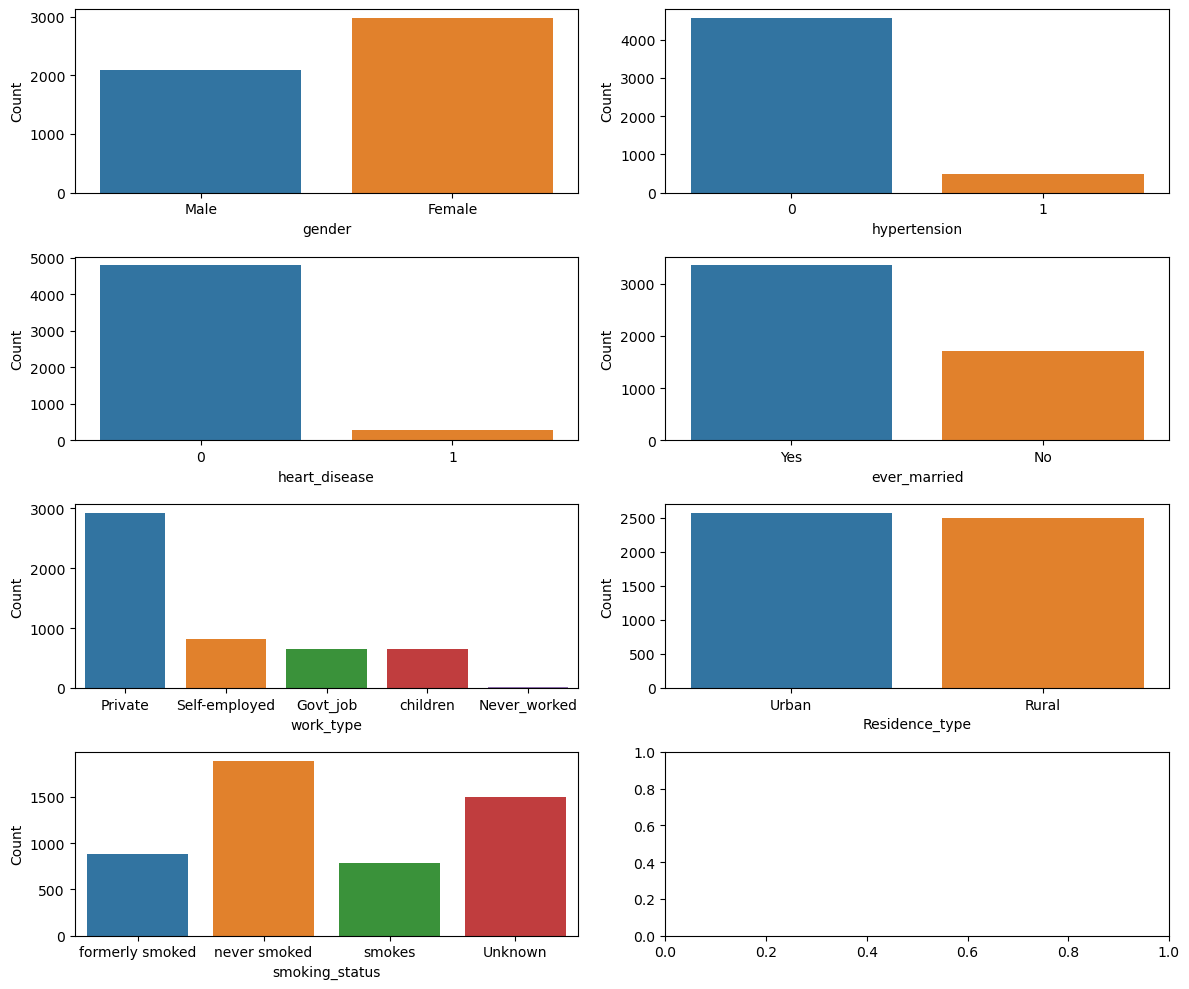

In [14]:
# Kategorik özelliklerin listesi
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Her bir özellik için ayrı grafik oluşturalım
fig, axes = plt.subplots(4, 2, figsize=(12, 10))  # 4x2 ızgara düzeninde alt grafiğe sahip bir figür oluşturalım

for i, ax in zip(columns, axes.flatten()):  # axes.flatten() ile düzleştirilmiş bir dizi elde edilir
    sns.countplot(data=df2, x=i, ax=ax)  # Seaborn countplot kullanarak sütun grafiği oluşturalım
    ax.set_xlabel(str(i))  # X eksenini özellik adı ile etiketleyelim
    ax.set_ylabel('Count')  # Y eksenini "Count" ile etiketleyelim

plt.tight_layout() 
plt.show()  

In [15]:
#Kadınların sayısı erkeklerden daha fazla
#Çoğu kişinin hipertansiyonu ve kalp rahatsızlığı yok.
#Çoğu kişi en az bir kere evlenmiş.
#Kişilerin çoğu özel sektörde çalışmakta. Kendi işini yapan, devlette çalışan ve çocuk sayıları hemen hemen birbirine eşit. Hiç çalışmayan çok az kişi var.
#Urban ve rural tipinde oturanların sayısı hemen hemen birbirine eşit.
#Hiç sigara içmeyen kişi sayısı daha fazla. Sigara içme durumu bilinmeyen kişi sayısı önemli denecek kadar çoktur.

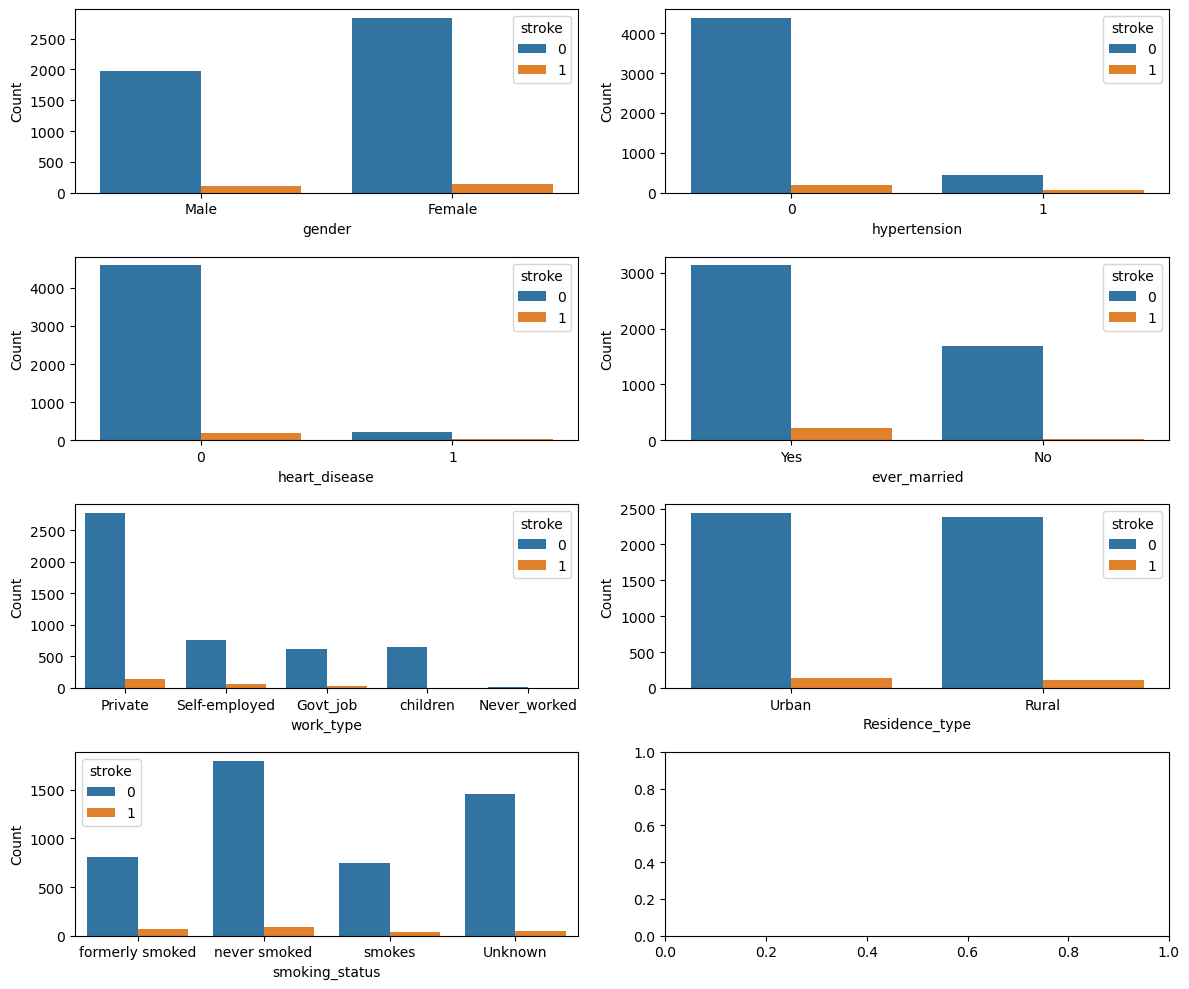

In [16]:
# Kategorik özelliklerin listesi
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Her bir özellik için ayrı grafik oluştur
fig, axes = plt.subplots(4, 2, figsize=(12, 10))

for i, ax in zip(columns, axes.flatten()):  # axes.flatten() ile düzleştirilmiş bir dizi elde edilir
    sns.countplot(data=df2, x=i, hue='stroke', ax=ax)  # Seaborn countplot kullanarak sütun grafiği oluşturalım
    ax.set_xlabel(str(i))  
    ax.set_ylabel('Count')  

plt.tight_layout()  
plt.show()

In [17]:
#Kadın ve erkeklerin çoğu felçli değil. Felç olmayan kadın sayısı erkeklerden daha fazla. 
#Hipertansiyonu olmayanlardan felç olanların sayısı hipertansiyonu olanların felç olan sayısından fazla
#Kalp hastalığı olmayanlardan felç olanlar kalp hastası olup da felç olanlardan daha fazla.
#En az bir kere evli olup felç olan sayısı fazladır.
#Özel sektörde çalışan veya kendi işini yapanlardan felç olanların sayısı diğerlerin fazla.
#Farklı yaşam yerlerinde yaşayan kişilerden felç olanlar birbirine hemen hemen eşittir.
#Hiç sigara içmeyen ve önceden sigara içenlerden felç olanlar diğerlerinden daha fazla.

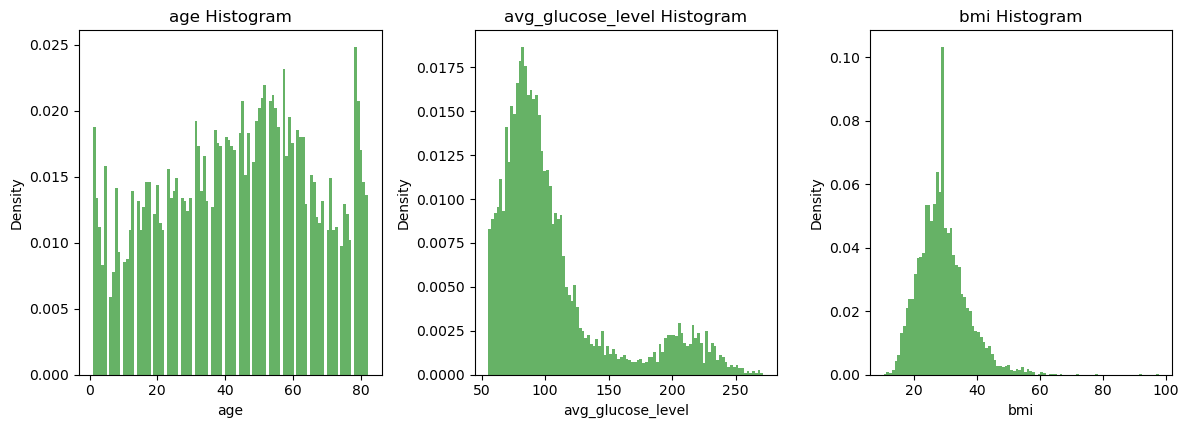

In [18]:
column = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(column):
        n_bins = 100
        ax.hist(df2[column[i]], bins=n_bins, density=True, alpha=0.6, color='g')
        ax.set_xlabel(column[i])
        ax.set_ylabel('Density')
        ax.set_title(column[i] + ' Histogram')

for i in range(len(column), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [19]:
#Hastaların yaş grubu değişkendir. 50-80 yaş aralığı çoğunlukta.
#Hastaların çoğunun ort glikoz seviyesi 50-125 arasında. Glikoz seviyesi daha yüksek kişiler de bulunmakta. Sağa çarpık dağılıma sahip.
#Hastalarının çoğunun bmisi 20-40 aralığında ama daha yüksek aykırı olan bmi değerleri vardır.

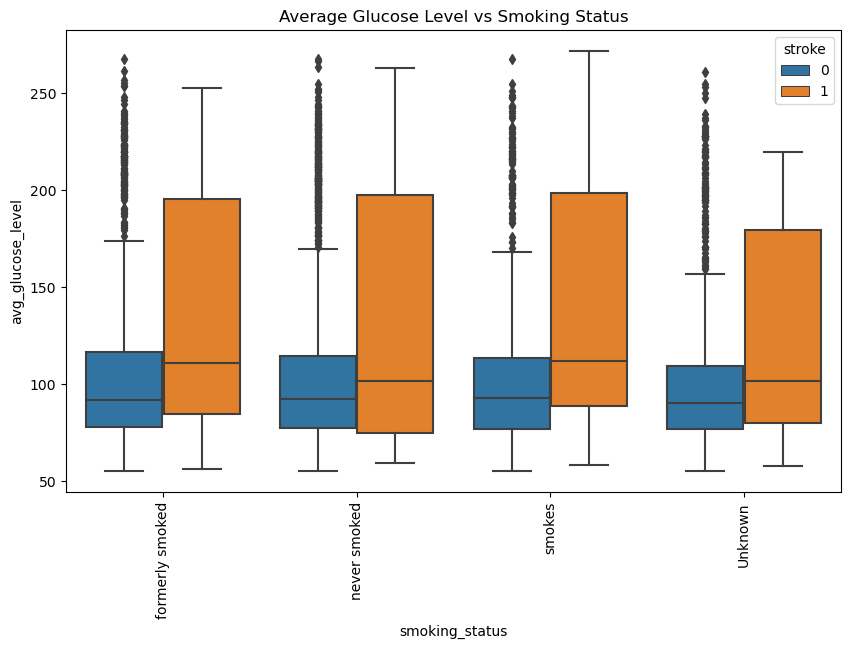

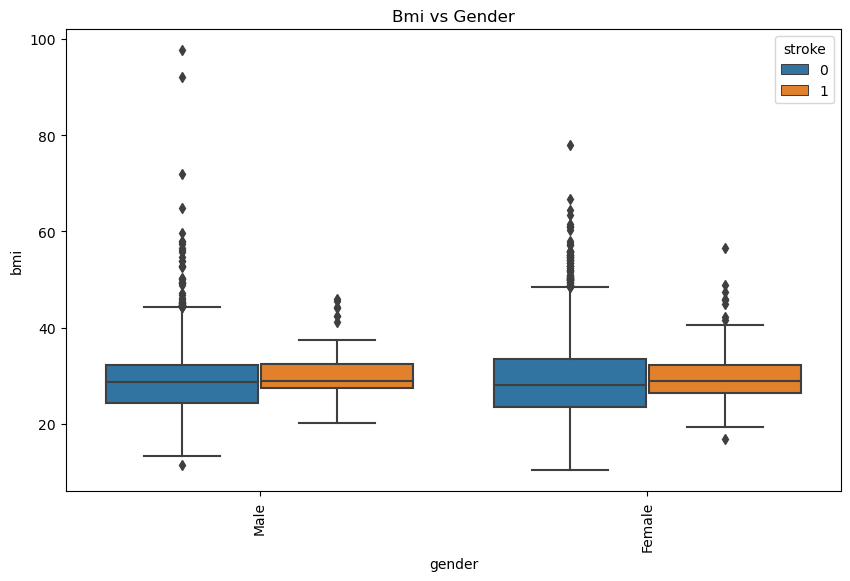

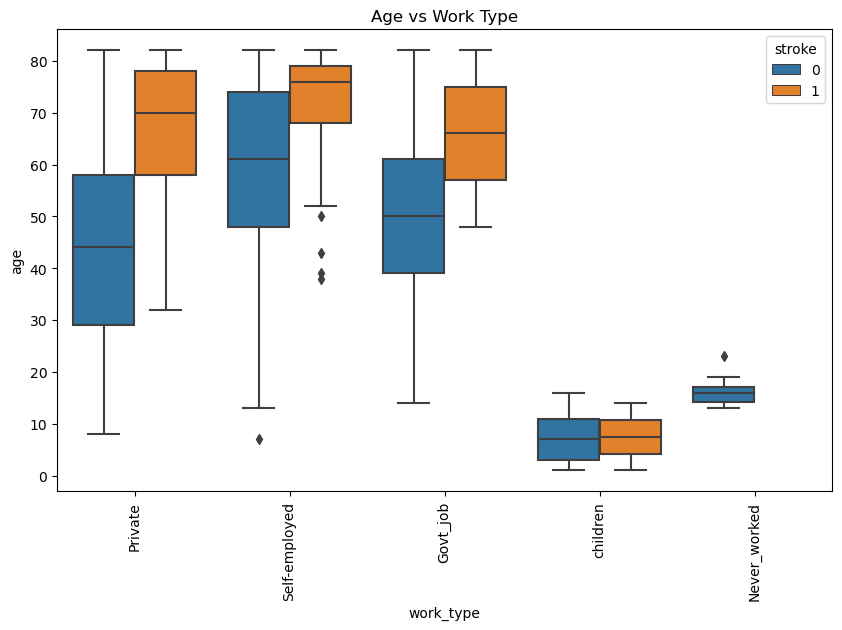

In [20]:
#stroke'e göre gruplanan smoking status ile avg glucose level kutu grafiği
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2['smoking_status'], y=df2['avg_glucose_level'], hue=df2['stroke'])
plt.title('Average Glucose Level vs Smoking Status')
plt.xticks(rotation=90)
plt.show()

#stroke'e göre gruplanan gender ile bmi kutu grafiği
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2['gender'], y=df2['bmi'], hue=df2['stroke'])
plt.title('Bmi vs Gender')
plt.xticks(rotation=90)
plt.show()

#stroke'e göre gruplanan age ile work type kutu grafiği
plt.figure(figsize=(10, 6))
sns.boxplot(x=df2['work_type'], y=df2['age'], hue=df2['stroke'])
plt.title('Age vs Work Type')
plt.xticks(rotation=90)
plt.show()

In [21]:
#Sigara içmeyen, önceden içen, hiç içmeyen ve bilinmeyen durumların ortalama glikoz seviyesinde aykırı değerler bulunmaktadır.
#Felç geçirenlerin hepsind ort glikoz seviyesi yüksektir.

#Erkek ve kadınların bmi dağılımı benzerdir. Erkek, felç olmamışların bmisinde aykırı değerler bulunmakta.
#Kadın ve felç olmamışların bmisinde aykırı değerler çok yüksektir.

#Yaşı 60 ve yüksek olup özel sektörde çalışanların felç olanları yüksektir.
#Yaşı 65 ve yukarı olup kendi işini yapanların felç olanları yüksektir.
#Hiç çalışmayanlardan felç olan yok.
#Felç olan çocuk yaş aralığı 5-10.

/tmp/ipykernel_20/3789633428.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['stroke'] = subset['stroke'].astype('category')
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


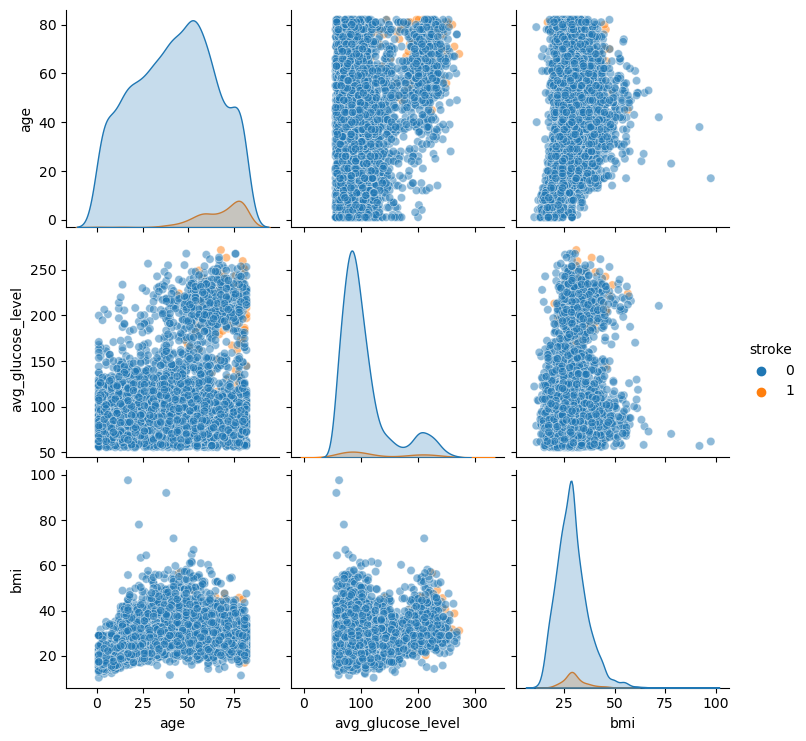

In [22]:
# Bir alt küme oluşturalım
subset = df2[['age', 'avg_glucose_level', 'bmi', 'stroke']]

# Pairplot graf için stroke kategorik değişken olmalı
subset['stroke'] = subset['stroke'].astype('category')

sns.pairplot(subset, hue='stroke', plot_kws={'alpha': 0.5})
plt.show()

In [23]:
#Yaş ve ort glikoz seviyesi arasında doğrusal bir ilişki yoktur. Fakat felçli olanların (turuncu) yaşı daha yaşlı olup ort glikoz seviyesi daha yüksektir.
#Yaş ve bmi arasında doğrusal bir ilişki yoktur. Felç olanların bmileri ile olmayanları bmi arasında çok bir farklılık yoktur.
#bmi ile ort glikoz seviyesi arasında doğrusal bir ilişki yoktur. Ancak felçli olanlaruın ort glikoz seviyesi daha yüksek.

#Yaş-yaş yoğunluk grafiğinde felç olanların yaşı daha yüksektir.
#Felç olanların ort glikoz seviyesi olmayankara göre daha yüksek.
#Felç olan ve olmaynların bmisinde anlamlı bir farklılık yoktur.

In [24]:
#BMI, felç için çok etkileyici bir değişken değilken yaş ve ort glikoz seviyesi hastanın felç olma tahmininde daha etkilidir.
#Kendi işini yapanlar ve zel sektörde çalışanlar daha yüksek felç geçirmiştir.

In [25]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5066 entries, 0 to 5066
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5066 non-null   object 
 1   age                5066 non-null   int64  
 2   hypertension       5066 non-null   int64  
 3   heart_disease      5066 non-null   int64  
 4   ever_married       5066 non-null   object 
 5   work_type          5066 non-null   object 
 6   Residence_type     5066 non-null   object 
 7   avg_glucose_level  5066 non-null   float64
 8   bmi                5066 non-null   float64
 9   smoking_status     5066 non-null   object 
 10  stroke             5066 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 474.9+ KB


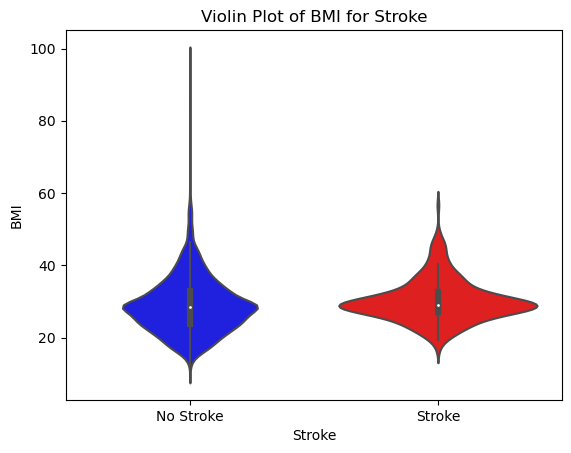

In [26]:
#Not: Bmi int değişken ve birçok datası var. Stroke kategorik ve 2 datası var.
# bmi değişkeninin stroke 0 ve stroke 1 için violin grafiğini çizelim
sns.violinplot(data=df2, x='stroke', y='bmi', palette={0: 'blue', 1: 'red'})
plt.xlabel('Stroke')
plt.ylabel('BMI')
plt.title('Violin Plot of BMI for Stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

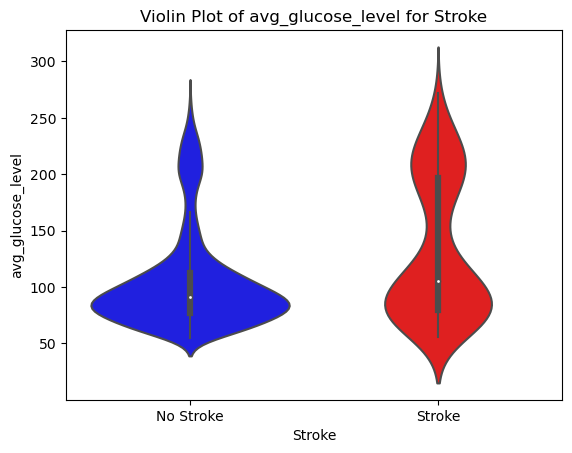

In [27]:
sns.violinplot(data=df2, x='stroke', y='avg_glucose_level', palette={0: 'blue', 1: 'red'})
plt.xlabel('Stroke')
plt.ylabel('avg_glucose_level')
plt.title('Violin Plot of avg_glucose_level for Stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

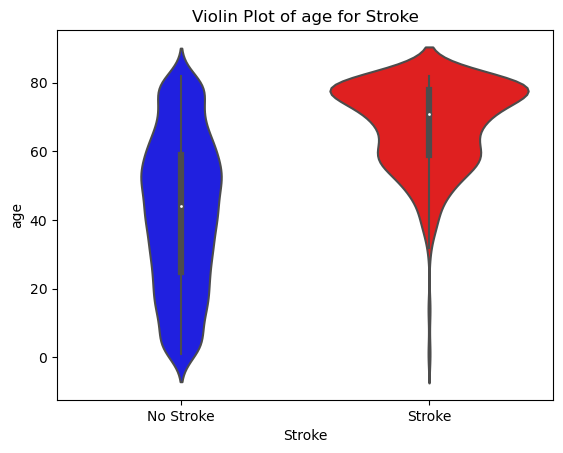

In [28]:
sns.violinplot(data=df2, x='stroke', y='age', palette={0: 'blue', 1: 'red'})
plt.xlabel('Stroke')
plt.ylabel('age')
plt.title('Violin Plot of age for Stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

In [29]:
# Her değişkenin çeyrekliklerini hesaplayalım
q1 = df2.quantile(0.25)
q3 = df2.quantile(0.75)

# Aykırı değerleri tespit etmek için çeyreklikleri kullanalım
lower_bound = q1 - 1.5 * (q3 - q1)
upper_bound = q3 + 1.5 * (q3 - q1)

# Her değişkendeki aykırı değer sayılarını hesaplayalım
outliers_count = ((df2 < lower_bound) | (df2 > upper_bound)).sum()

# Aykırı değer sayılarını ekrana bastıralım
print("Aykırı Değer Sayıları:")
print(outliers_count)

#stroke,hipertansiyon,kalp hastalığı 1ve 0 diye gruplandırıldığından (kategorik değişkenler) aykırı değer sayısını dikkate alma!!!
#int olan age'in hiç aykırı değeri yoktur.
#ort glikoz seviyesi ve bminin aykırı değerleri ile baş edeceğiz.

Aykırı Değer Sayıları:
Residence_type         0
age                    0
avg_glucose_level    627
bmi                  128
ever_married           0
gender                 0
heart_disease        276
hypertension         498
smoking_status         0
stroke               249
work_type              0
dtype: int64


/tmp/ipykernel_20/1833186695.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = df2.quantile(0.25)
/tmp/ipykernel_20/1833186695.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = df2.quantile(0.75)
/tmp/ipykernel_20/1833186695.py:10: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_count = ((df2 < lower_bound) | (df2 > upper_bound)).sum()


In [30]:
#Logaritmik dönüşüm yöntemini kullanalım:
df2['avg_glucose_level'] = np.log(df2['avg_glucose_level'])
df2['bmi'] = np.log(df2['bmi'])

In [31]:
#Tekrar aykırı değer sayılarını kontrol edelim
q1 = df2.quantile(0.25)
q3 = df2.quantile(0.75)
lower_bound = q1 - 1.5 * (q3 - q1)
upper_bound = q3 + 1.5 * (q3 - q1)

outliers_count = ((df2 < lower_bound) | (df2 > upper_bound)).sum()
print("Aykırı Değer Sayıları:")
print(outliers_count)

Aykırı Değer Sayıları:
Residence_type         0
age                    0
avg_glucose_level    381
bmi                   89
ever_married           0
gender                 0
heart_disease        276
hypertension         498
smoking_status         0
stroke               249
work_type              0
dtype: int64


/tmp/ipykernel_20/2704579160.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q1 = df2.quantile(0.25)
/tmp/ipykernel_20/2704579160.py:3: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  q3 = df2.quantile(0.75)
/tmp/ipykernel_20/2704579160.py:7: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  outliers_count = ((df2 < lower_bound) | (df2 > upper_bound)).sum()


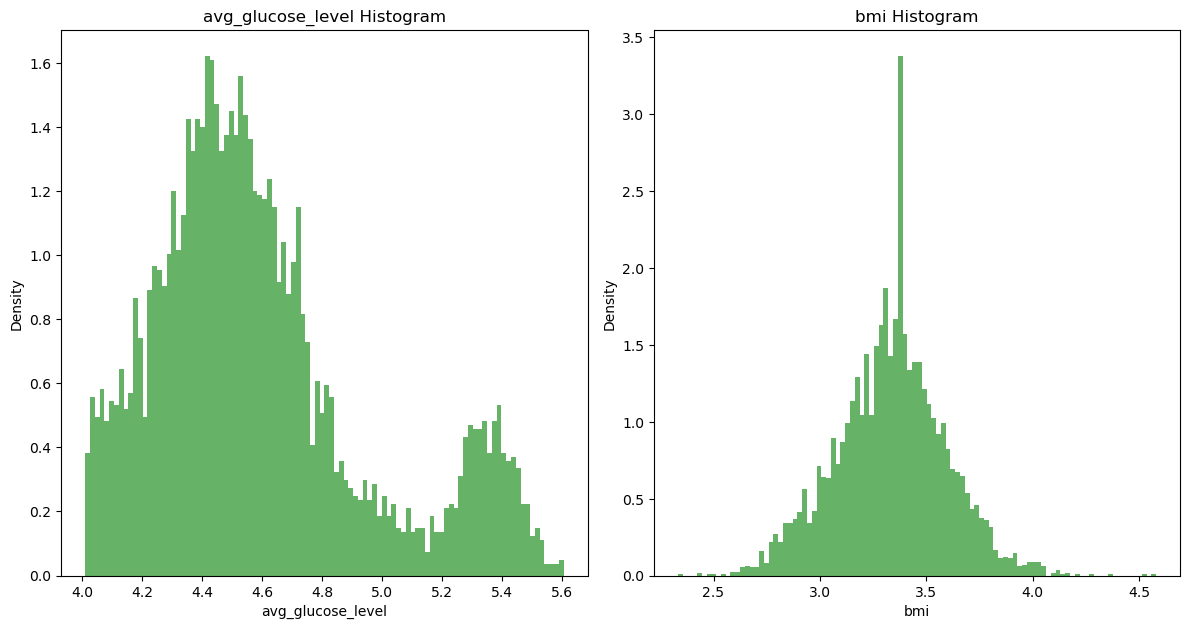

In [32]:
#Logaritmik dönüşümden sonra avg glucoz level ve bminin histogramları
column = ['avg_glucose_level', 'bmi']
fig, axes = plt.subplots(2,2, figsize=(12, 12))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(column):
        n_bins = 100
        ax.hist(df2[column[i]], bins=n_bins, density=True, alpha=0.6, color='g')
        ax.set_xlabel(column[i])
        ax.set_ylabel('Density')
        ax.set_title(column[i] + ' Histogram')
for i in range(len(column), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

/tmp/ipykernel_20/2345949986.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = heat_map_data.corr()


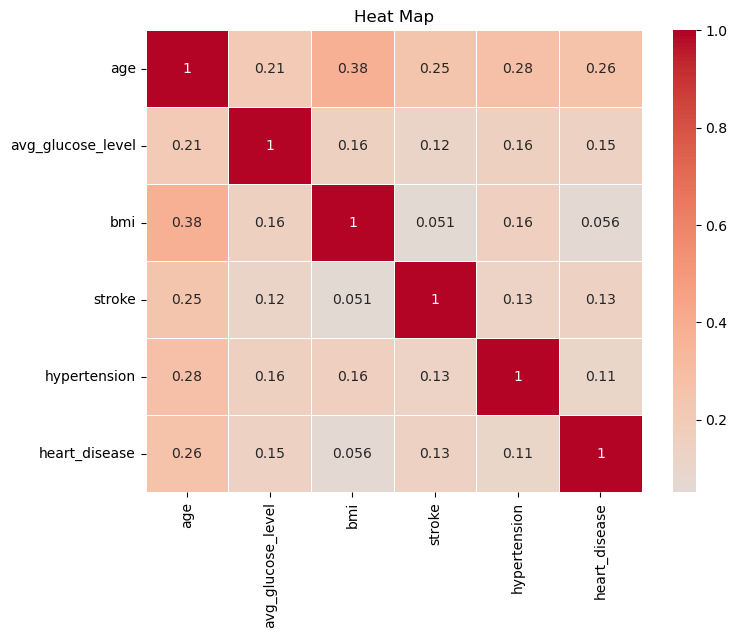

In [33]:
# Isı haritası için ilgili sütunları seçin (örneğin, "RESIDENTIAL UNITS", "COMMERCIAL UNITS" ve "TOTAL UNITS" gibi)
heat_map_data = df2[['age','avg_glucose_level','bmi','stroke',
                     'gender','ever_married','hypertension','heart_disease']]

# Korelasyon matrisini hesaplayalım
correlation_matrix = heat_map_data.corr()

# Isı haritasını çizelim
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Heat Map")
plt.show()

In [34]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,5.43,3.60,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,5.31,3.37,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,4.66,3.48,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,5.14,3.54,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,5.16,3.18,never smoked,1


In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5066 entries, 0 to 5066
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5066 non-null   object 
 1   age                5066 non-null   int64  
 2   hypertension       5066 non-null   int64  
 3   heart_disease      5066 non-null   int64  
 4   ever_married       5066 non-null   object 
 5   work_type          5066 non-null   object 
 6   Residence_type     5066 non-null   object 
 7   avg_glucose_level  5066 non-null   float64
 8   bmi                5066 non-null   float64
 9   smoking_status     5066 non-null   object 
 10  stroke             5066 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 474.9+ KB


In [36]:
data_encoded = pd.get_dummies(df2, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])

In [37]:
#Lojistik regresyon kullanarak hastanın felç geçirip geçirmemesini tahmin edelim

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

categorical_columns = ['gender', 'work_type', 'Residence_type', 'smoking_status']

df2['ever_married'] = df2['ever_married'].map({'No': 0, 'Yes': 1})
df2_encoded = pd.get_dummies(df2, columns=categorical_columns,drop_first=True)

# Bağımsız değişkenler (X) ve bağımlı değişken (y) ayırma
X = df2_encoded.drop(["stroke"],axis=1)
y = df2_encoded["stroke"]

# Veri kümesini eğitim ve test kümelerine bölmek
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sayısal özellikleri ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lojistik regresyon modelini oluşturma ve eğitme
logreg_model = LogisticRegression()
logreg_model.fit(X_train_scaled, y_train)

# Modelin test veri kümesi üzerinde performansını değerlendirme
accuracy = logreg_model.score(X_test_scaled, y_test)
# Modelin test veri kümesi üzerinde tahmin yapma
y_pred = logreg_model.predict(X_test_scaled)

# Tahmin sonuçlarını görmek için yazdırmass
print("Tahminler:", y_pred)

print("Model doğruluk değeri:", accuracy)

Tahminler: [0 0 0 ... 0 0 0]
Model doğruluk değeri: 0.9388560157790927


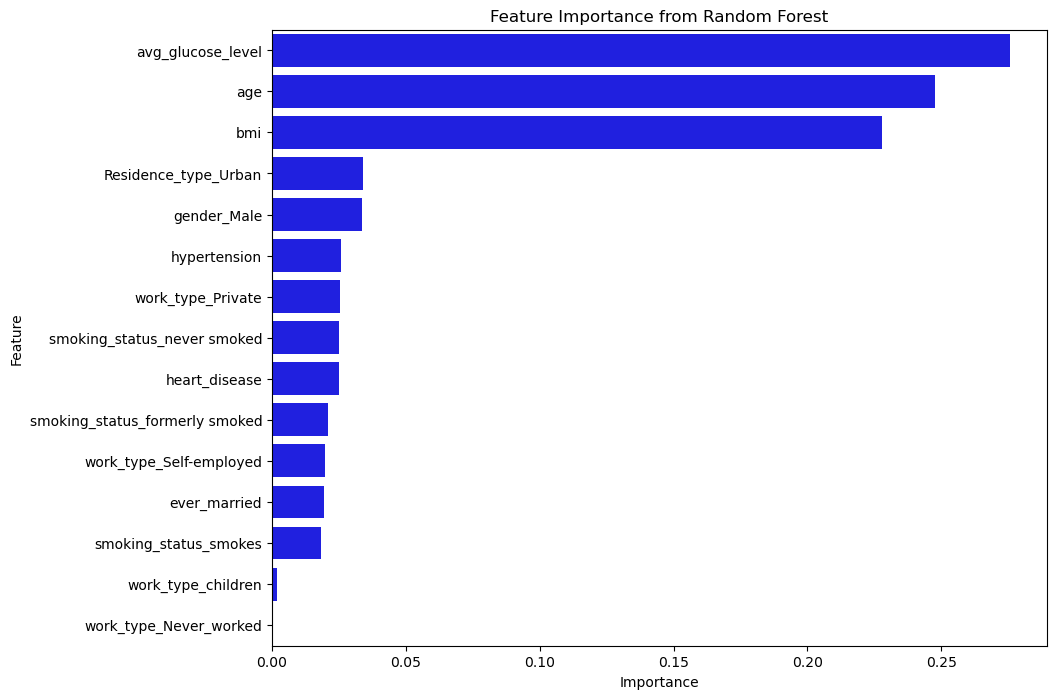

In [38]:
#Random Forrest Algoritması kurularak hastaların felç geçirme olasılığı tahmin edilirken değişkenlerin önem düzeylerini hesaplayalım:
X = df2_encoded.drop(columns='stroke')
y = df2_encoded['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

feature_importances = rf.feature_importances_


importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df, x='Importance', y='Feature', color='b')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()